# Time-series forecasting using LSTM

## Setup

In [1]:
!pip install yfinance torch scikit-learn seaborn matplotlib numpy pandas

In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt # Visualization 
import matplotlib.dates as mdates # Formatting dates
import seaborn as sns # Visualization
from sklearn.preprocessing import MinMaxScaler
import torch # Library for implementing Deep Neural Network 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from datetime import date, timedelta, datetime

## Load and setup the dataset

We are using the `yfinance` or the yahoo finance library to load stock market data.\
Read more about the library here - https://pypi.org/project/yfinance/

In [3]:
import yfinance as yf

In [4]:
# Get all the data from 2000 to today for Google stock (ticker = GOOG)
df = yf.download('AAPL', start='1990-01-01', end=date.today().strftime('%Y-%m-%d'))

[*********************100%%**********************]  1 of 1 completed


In [5]:
print(f"Dataset size - {df.shape}")

Dataset size - (8528, 6)


In [6]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1990-01-02,0.314732,0.334821,0.312500,0.332589,0.263761,183198400
1990-01-03,0.339286,0.339286,0.334821,0.334821,0.265531,207995200
1990-01-04,0.341518,0.345982,0.332589,0.335938,0.266416,221513600
1990-01-05,0.337054,0.341518,0.330357,0.337054,0.267302,123312000
1990-01-08,0.334821,0.339286,0.330357,0.339286,0.269072,101572800


## Visualizing the data

In [7]:
def plotData(df):

	ncols = 2
	nrows = int(round(df.shape[1] / ncols, 0))

    # Create a subplot for each dimension.
	fig, ax = plt.subplots(nrows=nrows, ncols=ncols,
						sharex=True, figsize=(12, 7))
	for i, ax in enumerate(fig.axes):
		sns.lineplot(data=df.iloc[:, i], ax=ax)
		ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
		ax.xaxis.set_major_locator(mdates.AutoDateLocator())
	fig.tight_layout()
	plt.show()

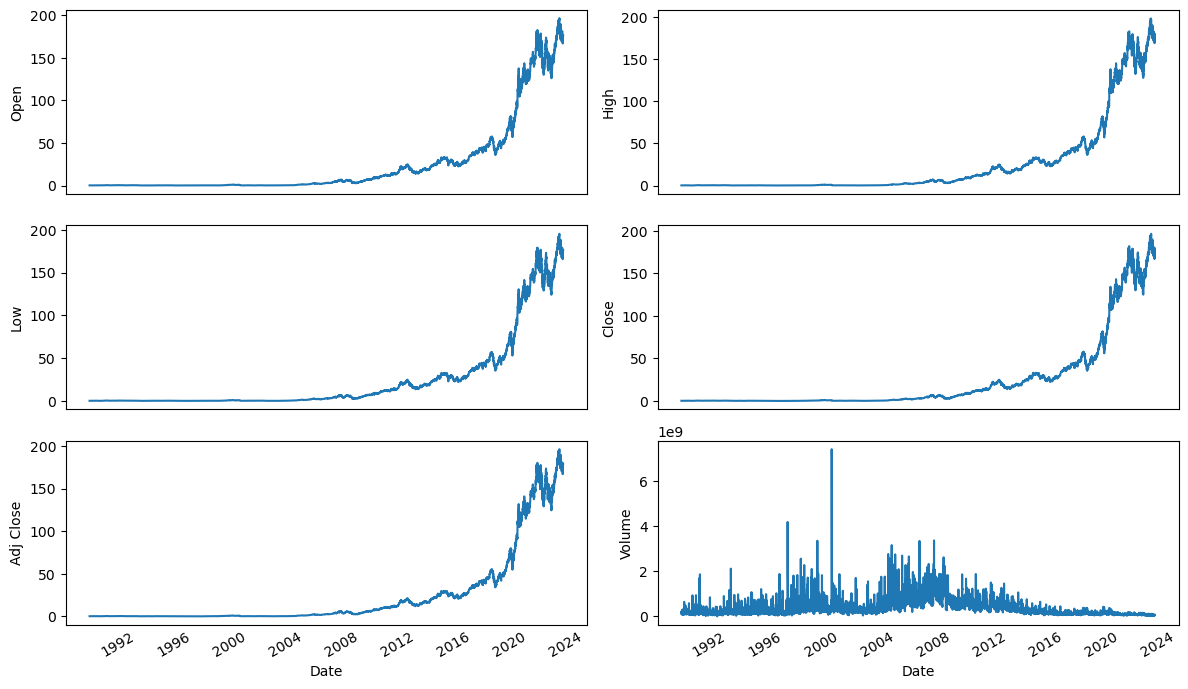

In [8]:
plotData(df)

## Training and Testing Datasets

We will do a standard 80-20 split for training and testing.

In [9]:
train_size = int(df.shape[0] * 0.8)

# We cannot randomly pick, as this is a time-series. Yn is conditional on Yn-1.
train_df = df[:train_size]
test_df = df[train_size:]

print(f"Size of the training and testing data sets {train_df.shape}, {test_df.shape}")
print(f"Start and end dates for training and testing data sets {train_df.index[0]}-{train_df.index[-1]},{test_df.index[0]}-{test_df.index[-1]}")

Size of the training and testing data sets (6822, 6), (1706, 6)
Start and end dates for training and testing data sets 1990-01-02 00:00:00-2017-01-26 00:00:00,2017-01-27 00:00:00-2023-11-06 00:00:00


We are going to use the "Close" modality of this dataset.

In [10]:
train_close_df = train_df['Close']
test_close_df = test_df['Close']

In [11]:
display(train_close_df[:5])
display(train_close_df.shape)

Date
1990-01-02    0.332589
1990-01-03    0.334821
1990-01-04    0.335938
1990-01-05    0.337054
1990-01-08    0.339286
Name: Close, dtype: float64

(6822,)

**Reshaping** - Both training and testing data are in the form of a pandas series, with the index as `Date` and the value as the series elements. Remember everything in ML is vectors. We would need to conver this into a vector form. Since we only have 1 feature (the closing value), we will convert this into a (N, 1) vector where N is the number of rows in the current series. We don't need the dates, since each timepoint is a single day and the order of the points maintains the time sequence.

In [12]:
train_close_df = np.reshape(train_close_df, (-1, 1))
test_close_df = np.reshape(test_close_df, (-1, 1))

In [13]:
print(train_close_df[:5])
print(train_close_df.shape)

[[0.332589  ]
 [0.33482099]
 [0.33593801]
 [0.33705401]
 [0.339286  ]]
(6822, 1)


## Preprocessing

ML models don't do well or converge slowly if the variables have difference scales. \
Learn more about preprocessing here - https://scikit-learn.org/stable/modules/preprocessing.html \
How you scale the data will depend on the the data is distributed. \
For our current model we will use the `MinMaxScalar` to normalize the data between [0,1]. \
Rare but if the values get too close 0, for example 0.1E-10, some processors may not have the floating point resolution to store them correctly. Additionally for long sequences you might run into dimenishing gradient problem, where the gradient becomes so small it cannot be correctly computed or stored using floating point precission. GPU's can help. But for longer sequences it is worth shifting to transformers.

In [14]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
train_norm = scaler.fit_transform(train_close_df)
test_norm = scaler.fit_transform(test_close_df)
print(train_norm[:5, 0]) 
print(test_norm[:5, 0])
print(*test_norm[:5])  # This looks like pointer math? This is the same as saying [:5, 0]. Just something new to explore :)

[0.00655136 0.00661872 0.00665243 0.00668612 0.00675348]
[0.000903   0.0004214  0.         0.01113703 0.01080593]
[0.000903] [0.0004214] [0.] [0.01113703] [0.01080593]


## Breaking it down into sequences.

One of the draw-backs of using an LSTM based approach is that the input size must be a fixed length. 
In order to do that we will need to take time-series and break it down into fixed length sequences. To handle variable length input sequences, an encoder-decorder model is used. Which is also at the heart of transformers. \

**Output Label** - Any supervised machine learning model must have an input vector $X$ and an output vector $Y$. In classification problems, $Y \epsilon \{class labels\}$, for regression problems $Y \epsilon \{response variable\}$.
In case of time-series forecasting, $Y$ will be a vector of values belonging to the same time-series which directly follow the sequence being used to train. In this notebook we use a sliding window to generate the sequences.

**Vector shape** - The vector shape will be $X=(M,N,k)$\
$M$ : Number of sequences \
$N$ : Points per sequence \
$k$ : Features per point 

In [15]:
# Method which will take a time-series and break it down X.

def createSequences(input_data : np.array, seq_length : int) -> (torch.tensor, torch.tensor) :
    if len(input_data) < seq_length:
        raise Exception(f"Sequence length of {seq_length} cannot be larger than the input_data length of {len(input_data)}")

    X = []
    Y = []
    for i in range(0, len(input_data) - seq_length):
        X.append(input_data[i:i+seq_length])
        Y.append(input_data[i+1:i+seq_length+1])  # The label data will shifted one ahead.

    # Convert them into pytorch tensors and return.
    return (torch.tensor(np.array(X), dtype=torch.float32), torch.tensor(np.array(Y), dtype=torch.float32))

We will go ahead and break down the input into 30 day sequence data. Longer sequences can help the model learn long term trends, but can also lead to vanishing gradient problem.

The training and testing does not need the same sequence length. To show this we will use a sequence length of 50 for training and 30 for testing.

In [16]:
(X_train, Y_train) = createSequences(train_norm, 50)
(X_test, Y_test) = createSequences(test_norm, 30)

print(f"Shape of the training vectors (X,Y) = {X_train.shape}, {Y_train.shape}")
print(f"Shape of the testing vectors (X,Y) = {X_test.shape}, {Y_test.shape}")

Shape of the training vectors (X,Y) = torch.Size([6772, 50, 1]), torch.Size([6772, 50, 1])
Shape of the testing vectors (X,Y) = torch.Size([1676, 30, 1]), torch.Size([1676, 30, 1])


## Model architecture

In this section we will define the NN model and the forward pass using PyTorch.\
Documentation on the PyTorch LSTM layer - https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html \
Documentation on the PyTorch Linear layer - https://pytorch.org/docs/stable/generated/torch.nn.Linear.html

**Batch First** - In the below model you will see that `batch_first` is set to `True`. This means that the LSTM layer expects the input to be in the format (batch, sequence, feature). If this was set to `False` then it would expect the input to be in the form of (seq, batch, feature). It is often easier to think in terms of the prior (with batch first) than with sequence first.

In [17]:
class SequenceModel(nn.Module): # Inherit from nn.Module
    def __init__(self, num_of_features, hidden_lstm_layers, lstm_layers):
        super(SequenceModel, self).__init__()  # Call the super / parent class
        # Define the neural network layers.
        self.lstm = nn.LSTM(num_of_features, hidden_lstm_layers, lstm_layers, batch_first=True)
        self.linear = nn.Linear(hidden_lstm_layers, 1)  # Takes the hidden features from LSTM and applies a linear transformation. 

    def forward(self, x): 
        # Defines how the layers are connected to each other.
        out, _ = self.lstm(x)
        out = self.linear(out)
        return out

**Hardware** - GPU make life faster. If you are running this notebook on a machine that has CUDA enabled GPU then the `device` variable will be set to `cuda` else it will get set to `cpu`. For our current notebook, a GPU is not requuired.

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## Loss function and GD Optimizer.

We will now define the loss / objective function that model will minimize during training (back propogation). 
We pick this to be MSE (Mean Square Error). \
Neural networks use a process of gradient descent to automatically set the learnable parameters in the model based on the derivative of the loss function. Variour optimizers for this can be used. \
List of all optimizers - https://pytorch.org/docs/stable/optim.html \
We will be using the Adam optimizer, which is a very common one used. 

**Note** - Back propogation works differently for recurant neural networks as compared to non-recurant NN. 
Refer to this link to learn more about it - https://towardsdatascience.com/backpropagation-in-rnn-explained-bdf853b4e1c2

In [19]:
model = SequenceModel(1, 32, 2).to(device)

We just created a model of the type `SequeceModel` that will take an input sequence with 1 input feature, 64 hidden lstm layers and 2 lstm stack on top of each other. We are also shifting the model `device`. If this machine has a GPU it will shift the computation to the CUDA supported GPU.

In [20]:
loss_fn = torch.nn.MSELoss(reduction='mean')

We just defined an instance of GD optimizer as adam, with a learning rate (`lr`) of 0.003

In [21]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # Pass the trainable params of the model

Let us look at the model now.

In [22]:
print(model)

SequenceModel(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (linear): Linear(in_features=32, out_features=1, bias=True)
)


## Creating batches.

Training and testing for NN models is often done in batches. We will now break the training and testing data into batches.
A low batch size can give better accuracy (but can also overfit), while taking more compute and larger training time.\
A larger batch size will approximate within the batch, and hence reduce accuracy but also reduce computation.

In [23]:
batch_size = 16

# Training batches.
train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Testing batches.
test_dataset = torch.utils.data.TensorDataset(X_test, Y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Training and Evaluation.

We are finally at the point where we can start to test and evaluate the model we have made. \
**epochs** - You will see this term used often when training NN. An epoch is one full training iteration for a NN model. 
Number of epochs must be balanced with the the accuracy, overfitting and training time. 

In [45]:
epochs = 10

train_loss = []
test_loss  = []

# Main training loop.
for epoch in range(epochs):
    total_loss = 0.0

    model.train()  # Set the params to be trainable.
    for batch_X, batch_Y in train_loader:
        # Shift the batch data to gpu / cpu.
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
        predictions = model(batch_X)  # Make a prediction (forward pass) 
        loss = loss_fn(predictions, batch_Y)  # Calculate the loss of this prediction.

        # Zero out the gradients.
        optimizer.zero_grad()
        loss.backward()  # Make a backward pass.
        optimizer.step()  # Perform the GD step using the learning rate (lr) to update the model params.
        total_loss += loss.item()

    # Calculating the average loss across all batches.
    avg_loss = total_loss / len(train_loader)
    train_loss.append(avg_loss)  # Per batch.

    # Perform model validation on the testing dataset.
    model.eval()  # Put the model in prediction mode (params are locked and cannot be trained)

    """
    Each operation on a tensor adds it to a DAG (Direced Acyclic Graph), so that gradients can be 
    computed using the chain rule during backward propogation. However during prediction, we don't want
    any operations on the tensors to be added to the DAG. We are NOT training. Hence we set torch.no_grad()
    for this part of the code. 
    """
    with torch.no_grad():
        total_test_loss = 0.0
        for batch_X, batch_Y in test_loader:
            predictions = model(batch_X)
            loss = loss_fn(predictions, batch_Y)
            total_test_loss += loss.item()  # Per batch.

        # Calculating the average loss across all batches.
        avg_loss = total_test_loss / len(test_loader)
        test_loss.append(avg_loss)

    # For every epoch print out the training and testing loss.
    print(f"Epoch - {epoch}. Training loss - {train_loss[-1]:.5f}. Testing loss - {test_loss[-1]:.5f}")

Epoch - 0. Training loss - 0.00003. Testing loss - 0.00016
Epoch - 1. Training loss - 0.00003. Testing loss - 0.00016
Epoch - 2. Training loss - 0.00004. Testing loss - 0.00017
Epoch - 3. Training loss - 0.00003. Testing loss - 0.00016
Epoch - 4. Training loss - 0.00003. Testing loss - 0.00016
Epoch - 5. Training loss - 0.00003. Testing loss - 0.00017
Epoch - 6. Training loss - 0.00003. Testing loss - 0.00016
Epoch - 7. Training loss - 0.00003. Testing loss - 0.00017
Epoch - 8. Training loss - 0.00003. Testing loss - 0.00016
Epoch - 9. Training loss - 0.00003. Testing loss - 0.00017


### Plotting the learning curve

In [25]:
def plotLearningCurve(total_epochs, train_loss, test_loss):
    x = np.linspace(1, total_epochs, total_epochs)
    plt.plot(x, train_loss, scalex=True, label='Training Loss')
    plt.plot(x, test_loss, scalex=True, label='Testing Loss')
    plt.legend()
    plt.show()

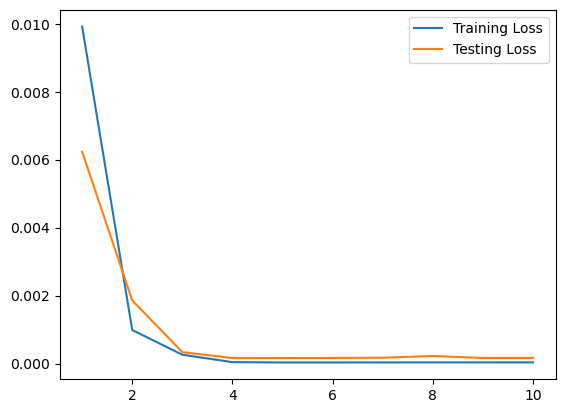

In [26]:
plotLearningCurve(epochs, train_loss, test_loss)

## Forecasting!

We now have a model that we have trained and can use for forecasting. \
For this forecasting we will use 30 days of data, to predict the next 30 days of data from it.

We introduce a few new methods for manipulating the shape of tensors

**Squeeze**

In machine learning when we often make vectors, the final dimensions represents the features per data point. In a univarient dataset the number of features per datapoint is often 1. If you want to remove singelton dimensions (those with a size of 1) you can use the `squeeze` method on the tensor. This is often needed when you want to graph the data. Look at the example below.

In [27]:
# Create a new tensor, with the last dimension as a singelton.
E = torch.randn(10, 3, 1)
# If we want to remove the final singelton diminsion as reduce it to (10, 3) to use for drawing a graph.
E1 = E.squeeze()
print(f"Before - {E.shape}, After - {E1.shape}")
# If you don't have any singelton dimensions, then the tensor is left as is.
E = torch.randn(10, 3, 3)
E1 = E.squeeze()
print(f"Before - {E.shape}, After - {E1.shape}")
# The singelton does not have to be the last dimension.
E = torch.randn(10, 1, 3, 3, 1)
E1 = E.squeeze()
print(f"Before - {E.shape}, After - {E1.shape}")

Before - torch.Size([10, 3, 1]), After - torch.Size([10, 3])
Before - torch.Size([10, 3, 3]), After - torch.Size([10, 3, 3])
Before - torch.Size([10, 1, 3, 3, 1]), After - torch.Size([10, 3, 3])


**Isolating the data we want to forecast on** 

We are going to use the last 30 days of data to predict 60 days in total. The first 30 days will overlap 

In [28]:
historic_data = test_norm[-30:]
print(historic_data.shape)

(30, 1)


In [29]:
historical_tensor = torch.as_tensor(historic_data).view(1, -1, 1).float().to(device)

In [30]:
with torch.no_grad():
    predicted_value = model(historical_tensor).cpu().numpy()

In [31]:
predicted_value.shape

(1, 30, 1)

**Forecasting method**

In [32]:
def forecast(horizon, historic_data):
    # This will store the future forecasted values.
    forecasted_values = []

    # Use the trained model to forecast future values
    # We use no_grad() again so that we don't change the DAG. 
    with torch.no_grad():
    	for _ in range(horizon):
    		"""
            .view() will change the shape of the incoming numpy array from (N, 1) to (batch, seq_length, features) 
            where batch=1, seq_length=N, features=1. The as_tensor() converts it from numpy to tensor. 
            .float() sets the datatype and .to(device) till put the tensor on GPU or CPU.
            """
    		historical_tensor = torch.as_tensor(historic_data).view(1, -1, 1).float().to(device)
    		# Use the model to predict the next value
    		predicted_value = model(historical_tensor).cpu().numpy()[0, 0]
    
    		# Append the predicted value to the forecasted_values list
    		forecasted_values.append(predicted_value[0])
    
    		# Update the historical_data sequence by removing the oldest value and adding the predicted value
    		historic_data = np.roll(historic_data, shift=-1)
    		historic_data[-1] = predicted_value

    return forecasted_values

In [33]:
forecasted_data = forecast(60, historic_data)

**Plot a snapshot of test data, all historic data and the predicted data on it.**

In [34]:
# Generate future dates.
def generateDates(df, start_date, days):
    dates = pd.date_range(start=start_date + pd.DateOffset(1), periods=30)
    combined_index = df.index.append(dates)
    return combined_index

In [35]:
def ForecastAndPlot():
    historic_data = test_norm[-30:]
    forecasted_data = forecast(60, historic_data)

    #set the size of the plot 
    plt.rcParams['figure.figsize'] = [14, 4] 
    
    #Test data
    plt.plot(test_df.index[-100:], test_df.Close[-100:], label = "test_data", color = "b") 
    #reverse the scaling transformation
    original_cases = scaler.inverse_transform(historic_data).flatten()
    
    #the historical data used as input for forecasting
    plt.plot(test_df.index[-30:], original_cases, label='actual values', color='green') 
    
    #Forecasted Values 
    #reverse the scaling transformation
    forecasted_cases = scaler.inverse_transform(np.expand_dims(forecasted_data, axis=0)).flatten() 
    # plotting the forecasted values
    future_dates = generateDates(test_df, test_df.index[-1], 30)
    plt.plot(future_dates[-60:], forecasted_cases, label='forecasted values', color='red') 
    
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.title('Time Series Forecasting')
    plt.grid(True)

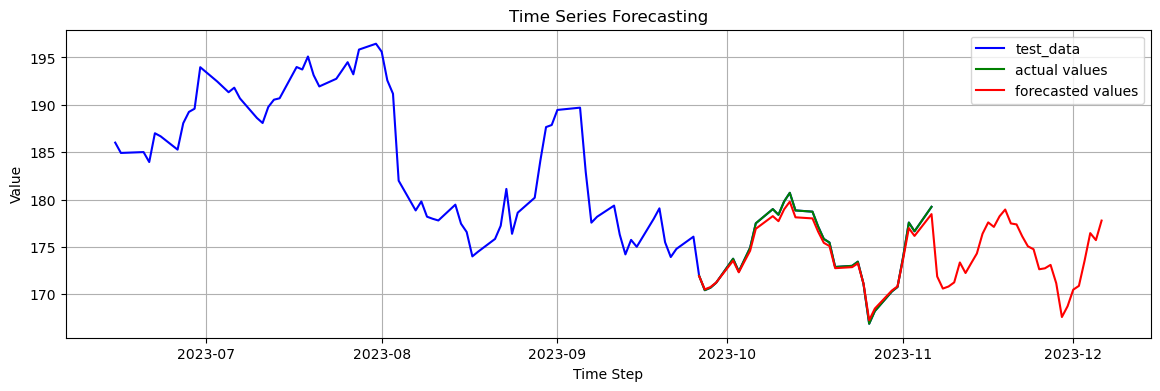

In [36]:
ForecastAndPlot()

In [37]:
def ForecastAndPlot():
    historic_data = test_norm[-120:-90]
    forecasted_data = forecast(60, historic_data)

    #set the size of the plot 
    plt.rcParams['figure.figsize'] = [14, 4] 
    
    #Test data
    plt.plot(test_df.index[-200:], test_df.Close[-200:], label = "test_data", color = "b") 
    #reverse the scaling transformation
    original_cases = scaler.inverse_transform(historic_data).flatten()
    
    #the historical data used as input for forecasting
    plt.plot(test_df.index[-120:-90], original_cases, label='actual values', color='green') 
    
    #Forecasted Values 
    #reverse the scaling transformation
    forecasted_cases = scaler.inverse_transform(np.expand_dims(forecasted_data, axis=0)).flatten() 
    # plotting the forecasted values
    #future_dates = generateDates(test_df, test_df.index[-1], 60)
    plt.plot(test_df.index[-120:-60], forecasted_cases, label='forecasted values', color='red') 
    
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.title('Time Series Forecasting')
    plt.grid(True)

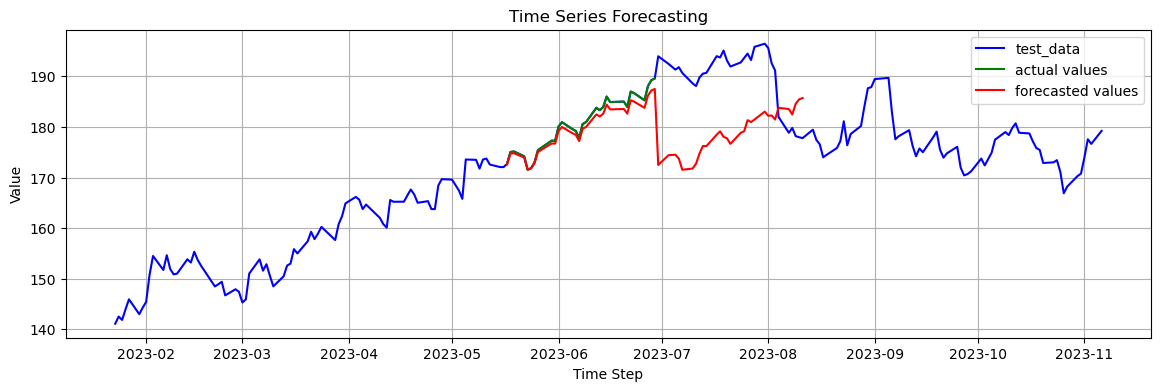

In [38]:
ForecastAndPlot()

In [46]:
def ForecastAndPlot():
    historic_data = test_norm[-150:-120]
    forecasted_data = forecast(60, historic_data)

    #set the size of the plot 
    plt.rcParams['figure.figsize'] = [14, 4] 
    
    #Test data
    plt.plot(test_df.index[-200:], test_df.Close[-200:], label = "test_data", color = "b") 
    #reverse the scaling transformation
    original_cases = scaler.inverse_transform(historic_data).flatten()
    
    #the historical data used as input for forecasting
    plt.plot(test_df.index[-150:-120], original_cases, label='actual values', color='green') 
    
    #Forecasted Values 
    #reverse the scaling transformation
    forecasted_cases = scaler.inverse_transform(np.expand_dims(forecasted_data, axis=0)).flatten() 
    # plotting the forecasted values
    #future_dates = generateDates(test_df, test_df.index[-1], 60)
    plt.plot(test_df.index[-150:-90], forecasted_cases, label='forecasted values', color='red') 
    
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.title('Time Series Forecasting')
    plt.grid(True)

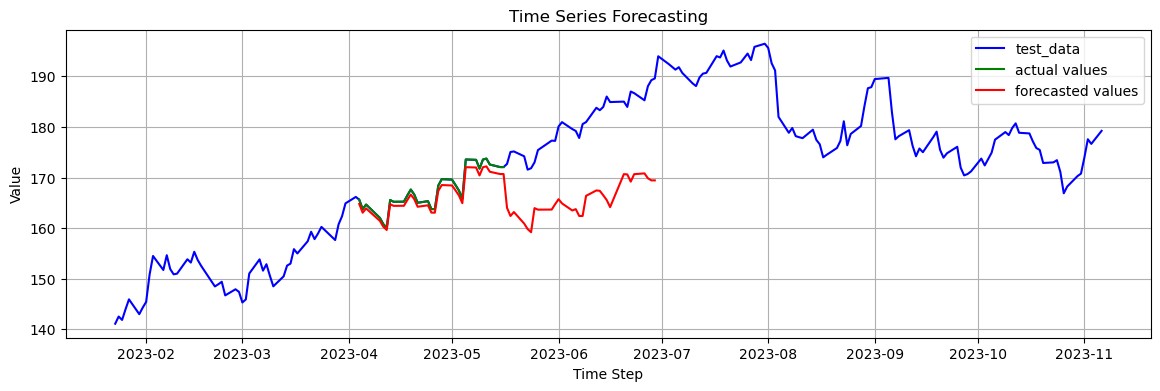

In [47]:
ForecastAndPlot()

### Conclusion

Stock market data is inherrently very difficult to fit time-series models on. In each of the examples the model is predicting 60 days of data in total by looking at a 30 day window of data. \
**Example 1** - The model looks at the 30 day window at the end of the time-series. It models the peak it saw in the last 30 days in the prediction. \
**Example 2** - The model correctly predicts the first 30 days, however it predicts a sudden drop followed by a gradual increase. During its training the model saw that if there is a continuous increase in the price for most of 30 days, it might be followed by a sudden drop. It also had learned that sudden drops are usually accompanied by slow increases in the closing price. Without additional features to guide it, the closing price alone would not be able to model the sudden drops and rises accurately. \
**Example 3** - the model predicts a slower rise as compared to the actual price data. It again exhibits the same property as example 2, where is predicts a drop after continuous price increase and then a gradual increase. 